In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('6.csv')

In [ ]:
column_mapping = {
    'Athlete': 'athlete',
    'Date': 'date',
    'Day.of.Week': 'day_of_week',
    'RHR': 'rhr',
    'HRV': 'hrv',
    'Recovery': 'recovery',
    'Sleep.Score': 'sleep_score',
    'Hours.in.Bed': 'hours_in_bed',
    'Hours.of.Sleep': 'hours_of_sleep',
    'Sleep.Need': 'sleep_need',
    'Sleep.Efficiency....': 'sleep_efficiency',
    'Wake.Periods': 'wake_periods',
    'Sleep.Disturbances': 'sleep_disturbances',
    'Latency..min.': 'latency_min',
    'Cycles': 'cycles',
    'REM.Sleep..hours.': 'rem_sleep_hours',
    'Deep.Sleep..hours.': 'deep_sleep_hours',
    'Light.Sleep..hours.': 'light_sleep_hours',
    'Awake..hours.': 'awake_hours',
    'Sleep.Debt..hours.': 'sleep_debt_hours',
    'Sleep.Consistency': 'sleep_consistency',
    'Respiratory.Rate': 'respiratory_rate',
    'Total.Cycle.Sleep.Time..hours.': 'total_cycle_sleep_time_hours',
    'REM.Percentage': 'rem_percentage',
    'Deep.Sleep.Percentage': 'deep_sleep_percentage',
    'Restorative.Sleep..hours.': 'restorative_sleep_hours',
    'Restorative.Sleep....': 'restorative_sleep'
}

df = df.rename(columns=column_mapping)

In [ ]:
print(df.columns)

Index(['athlete', 'date', 'day_of_week', 'rhr', 'hrv', 'recovery',
       'sleep_score', 'hours_in_bed', 'hours_of_sleep', 'sleep_need',
       'sleep_efficiency', 'wake_periods', 'sleep_disturbances', 'latency_min',
       'cycles', 'rem_sleep_hours', 'deep_sleep_hours', 'light_sleep_hours',
       'awake_hours', 'sleep_debt_hours', 'sleep_consistency',
       'respiratory_rate', 'total_cycle_sleep_time_hours', 'rem_percentage',
       'deep_sleep_percentage', 'restorative_sleep_hours', 'restorative_sleep',
       'RSI'],
      dtype='object')


In [ ]:
print(df.isna().sum())

athlete                            0
date                               0
day_of_week                     1124
rhr                             1130
hrv                             1130
recovery                        1130
sleep_score                     1130
hours_in_bed                    1130
hours_of_sleep                  1130
sleep_need                      1130
sleep_efficiency                1130
wake_periods                    1490
sleep_disturbances              1130
latency_min                     1130
cycles                          1130
rem_sleep_hours                 1130
deep_sleep_hours                1130
light_sleep_hours               1130
awake_hours                     1130
sleep_debt_hours                1130
sleep_consistency               1401
respiratory_rate                1134
total_cycle_sleep_time_hours    1130
rem_percentage                  1130
deep_sleep_percentage           1130
restorative_sleep_hours         1130
restorative_sleep               1130
R

In [ ]:
print(df.dtypes)

athlete                          object
date                             object
day_of_week                      object
rhr                             float64
hrv                             float64
recovery                        float64
sleep_score                     float64
hours_in_bed                    float64
hours_of_sleep                  float64
sleep_need                      float64
sleep_efficiency                float64
wake_periods                    float64
sleep_disturbances              float64
latency_min                     float64
cycles                          float64
rem_sleep_hours                 float64
deep_sleep_hours                float64
light_sleep_hours               float64
awake_hours                     float64
sleep_debt_hours                float64
sleep_consistency               float64
respiratory_rate                float64
total_cycle_sleep_time_hours    float64
rem_percentage                  float64
deep_sleep_percentage           float64


In [ ]:
#df.head(20)

In [ ]:
original_df = df.copy()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from datetime import datetime, timedelta

# convert date to datetime format
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

# Create a copy of RSI column for our custom imputation
df['RSI_filled'] = df['RSI'].copy()

# Sort the dataframe by athlete and date
df = df.sort_values(['athlete', 'date'])

# Get list of all athletes
athletes = df['athlete'].unique()

# Custom RSI imputation for each athlete
for athlete in athletes:
    athlete_df = df[df['athlete'] == athlete].copy()

    # Get indices where RSI is not NaN
    rsi_indices = athlete_df[~athlete_df['RSI'].isna()].index

    for idx in rsi_indices:
        rsi_value = df.loc[idx, 'RSI']
        current_date = df.loc[idx, 'date']

        # Look back up to 13 days
        for days_back in range(1, 14):
            back_date = current_date - timedelta(days=days_back)

            # Find rows for this athlete and this back date
            back_indices = df[(df['athlete'] == athlete) &
                              (df['date'] == back_date)].index

            # If there's a row for this back date
            if len(back_indices) > 0:
                back_idx = back_indices[0]

                # Check if there's an RSI value or we already filled it
                if pd.isna(df.loc[back_idx, 'RSI']) and pd.isna(df.loc[back_idx, 'RSI_filled']):
                    df.loc[back_idx, 'RSI_filled'] = rsi_value
                else:
                    # Stop backfilling if we encounter a non-NaN value
                    break

# Fill day_of_week based on date
df['day_of_week'] = df['date'].dt.day_name()

# Define columns to exclude from MICE imputation
excluded_columns = ['athlete', 'date', 'day_of_week', 'RSI', 'RSI_filled']

# Get columns to impute with MICE
columns_to_impute = [col for col in df.columns if col not in excluded_columns]

# For MICE imputation, we'll impute each athlete separately to avoid mixing their data
for athlete in athletes:
    athlete_mask = df['athlete'] == athlete

    # Extract numeric data for this athlete
    athlete_data = df.loc[athlete_mask, columns_to_impute].copy()

    # Skip if all rows are NaN
    if athlete_data.isna().all().all():
        continue

    # Initialize and fit the MICE imputer
    imputer = IterativeImputer(max_iter=10, random_state=42)

    # Impute data
    imputed_data = imputer.fit_transform(athlete_data)

    # Update the original dataframe with imputed values
    df.loc[athlete_mask, columns_to_impute] = imputed_data

# Display stats after imputation
print("NA values after imputation:")
print(df.isna().sum())

NA values after imputation:
athlete                            0
date                               0
day_of_week                        0
rhr                                0
hrv                                0
recovery                           0
sleep_score                        0
hours_in_bed                       0
hours_of_sleep                     0
sleep_need                         0
sleep_efficiency                   0
wake_periods                       0
sleep_disturbances                 0
latency_min                        0
cycles                             0
rem_sleep_hours                    0
deep_sleep_hours                   0
light_sleep_hours                  0
awake_hours                        0
sleep_debt_hours                   0
sleep_consistency                  0
respiratory_rate                   0
total_cycle_sleep_time_hours       0
rem_percentage                     0
deep_sleep_percentage              0
restorative_sleep_hours            0
restorativ

In [ ]:
df.head(35)

,athlete,date,day_of_week,rhr,hrv,recovery,sleep_score,hours_in_bed,hours_of_sleep,sleep_need,...,sleep_debt_hours,sleep_consistency,respiratory_rate,total_cycle_sleep_time_hours,rem_percentage,deep_sleep_percentage,restorative_sleep_hours,restorative_sleep,RSI,RSI_filled
179,Athlete 1 Bergdorf,2021-09-06,Monday,51.0,129.0,73.0,100.0,9.81,9.05,9.06,...,1.24,59.0,13.0078,9.05,19.5,17.8,3.66,37.3,NaN,0.32
180,Athlete 1 Bergdorf,2021-09-07,Tuesday,45.0,129.0,70.0,65.0,5.18,5.07,7.79,...,0.00,64.0,12.2461,5.07,29.5,26.1,2.88,55.6,NaN,0.32
181,Athlete 1 Bergdorf,2021-09-08,Wednesday,47.0,132.0,76.0,75.0,7.67,7.27,9.69,...,1.35,50.0,12.1094,7.27,24.0,24.0,3.68,48.0,NaN,0.32
182,Athlete 1 Bergdorf,2021-09-09,Thursday,49.0,130.0,67.0,55.0,5.52,5.40,9.89,...,1.24,66.0,11.8359,5.40,33.7,27.9,3.40,61.6,NaN,0.32
158,Athlete 1 Bergdorf,2021-09-10,Friday,47.0,155.0,86.0,79.0,6.47,6.16,7.84,...,1.74,52.0,12.1875,8.20,30.4,28.4,3.81,58.9,NaN,0.32
159,Athlete 1 Bergdorf,2021-09-11,Saturday,46.0,142.0,79.0,86.0,7.64,7.05,8.22,...,1.05,46.0,12.1289,8.25,30.2,27.2,4.39,57.5,NaN,0.32
160,Athlete 1 Bergdorf,2021-09-12,Sunday,49.0,137.0,72.0,62.0,5.64,5.24,8.49,...,0.70,54.0,12.1875,5.24,31.7,27.7,3.35,59.4,NaN,0.32
161,Athlete 1 Bergdorf,2021-09-13,Monday,46.0,133.0,72.0,64.0,6.21,5.95,9.26,...,1.47,65.0,11.8945,5.95,33.5,34.0,4.19,67.5,0.32,0.32
162,Athlete 1 Bergdorf,2021-09-14,Tuesday,49.0,133.0,73.0,75.0,6.58,6.41,8.50,...,1.39,57.0,12.1289,7.63,29.2,27.4,3.72,56.5,NaN,0.26
163,Athlete 1 Bergdorf,2021-09-15,Wednesday,48.0,142.0,81.0,57.0,5.51,5.39,9.46,...,1.24,54.0,12.1875,5.39,41.4,23.4,3.57,64.8,NaN,0.26


In [ ]:
# drop RSI column from df
df = df.drop('RSI', axis=1)

In [ ]:
#rename RSI_filled to RSI
df = df.rename(columns={'RSI_filled': 'RSI'})

In [ ]:
df.shape

(3111, 28)

In [ ]:
print("NA values after imputation:")
print(df.isna().sum())

NA values after imputation:
athlete                            0
date                               0
day_of_week                        0
rhr                                0
hrv                                0
recovery                           0
sleep_score                        0
hours_in_bed                       0
hours_of_sleep                     0
sleep_need                         0
sleep_efficiency                   0
wake_periods                       0
sleep_disturbances                 0
latency_min                        0
cycles                             0
rem_sleep_hours                    0
deep_sleep_hours                   0
light_sleep_hours                  0
awake_hours                        0
sleep_debt_hours                   0
sleep_consistency                  0
respiratory_rate                   0
total_cycle_sleep_time_hours       0
rem_percentage                     0
deep_sleep_percentage              0
restorative_sleep_hours            0
restorativ

In [ ]:
#drop null rows from RSI
df = df.dropna(subset=['RSI'])

In [ ]:
df.shape

(1744, 28)

In [ ]:
imputed_df = df.copy()

In [ ]:
df.to_csv('imputed_athlete_data.csv', index=False)

In [ ]:
cols_with_na = original_df.columns[original_df.isnull().any()].tolist()

In [ ]:
comparison_data = []

for col in cols_with_na:
    if col in imputed_df.columns and pd.api.types.is_numeric_dtype(imputed_df[col]):
        orig_col_non_na = original_df[col].dropna()
        imp_col = imputed_df[col]

        orig_mean = orig_col_non_na.mean()
        orig_std = orig_col_non_na.std()

        imp_mean = imp_col.mean()
        imp_std = imp_col.std()

        mean_error_pct = abs((imp_mean - orig_mean) / orig_mean) * 100 if orig_mean != 0 else np.nan
        std_error_pct = abs((imp_std - orig_std) / orig_std) * 100 if orig_std != 0 else np.nan

        comparison_data.append({
            'Feature': col,
            'Original Mean': round(orig_mean, 2),
            'Imputed Mean': round(imp_mean, 2),
            '% Mean Error': round(mean_error_pct, 2),
            'Original Std': round(orig_std, 2),
            'Imputed Std': round(imp_std, 2),
            '% Std Error': round(std_error_pct, 2)
        })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.sort_values('% Mean Error', ascending=False))


                         Feature  Original Mean  Imputed Mean  % Mean Error  \
8                   wake_periods          14.87         14.19          4.56   
10                   latency_min           2.89          2.76          4.21   
2                       recovery          59.55         61.45          3.19   
17             sleep_consistency          62.59         60.69          3.04   
1                            hrv          84.07         85.80          2.07   
24                           RSI           0.38          0.37          1.68   
11                        cycles           5.30          5.24          1.26   
12               rem_sleep_hours           2.04          2.02          1.20   
20                rem_percentage          26.37         26.12          0.96   
13              deep_sleep_hours           1.37          1.36          0.74   
15                   awake_hours           0.90          0.89          0.70   
16              sleep_debt_hours           0.98     

In [ ]:
# Markdown-style table (copy-paste friendly for most editors)
print(comparison_df.to_markdown(index=False))


| Feature                      |   Original Mean |   Imputed Mean |   % Mean Error |   Original Std |   Imputed Std |   % Std Error |
|:-----------------------------|----------------:|---------------:|---------------:|---------------:|--------------:|--------------:|
| rhr                          |           59.69 |          59.59 |           0.16 |           9    |          8.27 |          8.17 |
| hrv                          |           84.07 |          85.8  |           2.07 |          36.11 |         33.63 |          6.86 |
| recovery                     |           59.55 |          61.45 |           3.19 |          22.66 |         19.06 |         15.91 |
| sleep_score                  |           76.39 |          76.27 |           0.17 |          18.55 |         15.65 |         15.67 |
| hours_in_bed                 |            7.78 |           7.76 |           0.33 |           1.93 |          1.62 |         15.91 |
| hours_of_sleep               |            6.89 |           6

In [ ]:
print(comparison_df.to_latex(index=False, float_format="%.2f"))


\begin{tabular}{lrrrrrr}
\toprule
Feature & Original Mean & Imputed Mean & % Mean Error & Original Std & Imputed Std & % Std Error \\
\midrule
rhr & 59.69 & 59.59 & 0.16 & 9.00 & 8.27 & 8.17 \\
hrv & 84.07 & 85.80 & 2.07 & 36.11 & 33.63 & 6.86 \\
recovery & 59.55 & 61.45 & 3.19 & 22.66 & 19.06 & 15.91 \\
sleep_score & 76.39 & 76.27 & 0.17 & 18.55 & 15.65 & 15.67 \\
hours_in_bed & 7.78 & 7.76 & 0.33 & 1.93 & 1.62 & 15.91 \\
hours_of_sleep & 6.89 & 6.87 & 0.26 & 1.65 & 1.38 & 16.28 \\
sleep_need & 8.91 & 8.92 & 0.09 & 1.12 & 0.97 & 13.20 \\
sleep_efficiency & 88.87 & 88.96 & 0.10 & 6.30 & 5.32 & 15.48 \\
wake_periods & 14.87 & 14.19 & 4.56 & 6.61 & 5.92 & 10.42 \\
sleep_disturbances & 11.63 & 11.70 & 0.60 & 5.61 & 5.03 & 10.29 \\
latency_min & 2.89 & 2.76 & 4.21 & 5.28 & 4.20 & 20.43 \\
cycles & 5.30 & 5.24 & 1.26 & 2.18 & 1.83 & 16.17 \\
rem_sleep_hours & 2.04 & 2.02 & 1.20 & 0.79 & 0.67 & 14.43 \\
deep_sleep_hours & 1.37 & 1.36 & 0.74 & 0.46 & 0.39 & 13.90 \\
light_sleep_hours & 3.47 &

#### ATP df includes, RSI values properly imputed backward at max till 13, days still 1300 missing values, MICE Impute done for non target variables.

#### NOW model building

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # Importing the RandomForestRegressor class
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay


In [ ]:
df = df.drop('RSI', axis=1)

Mean Squared Error: 0.0034
R-squared: 0.3702

Top 10 features for RSI prediction:
                  Feature  Importance
18       respiratory_rate    0.308180
1                     hrv    0.129156
17      sleep_consistency    0.061987
6              sleep_need    0.044368
0                     rhr    0.043945
15            awake_hours    0.041342
16       sleep_debt_hours    0.028663
3             sleep_score    0.026956
10            latency_min    0.025723
21  deep_sleep_percentage    0.025376


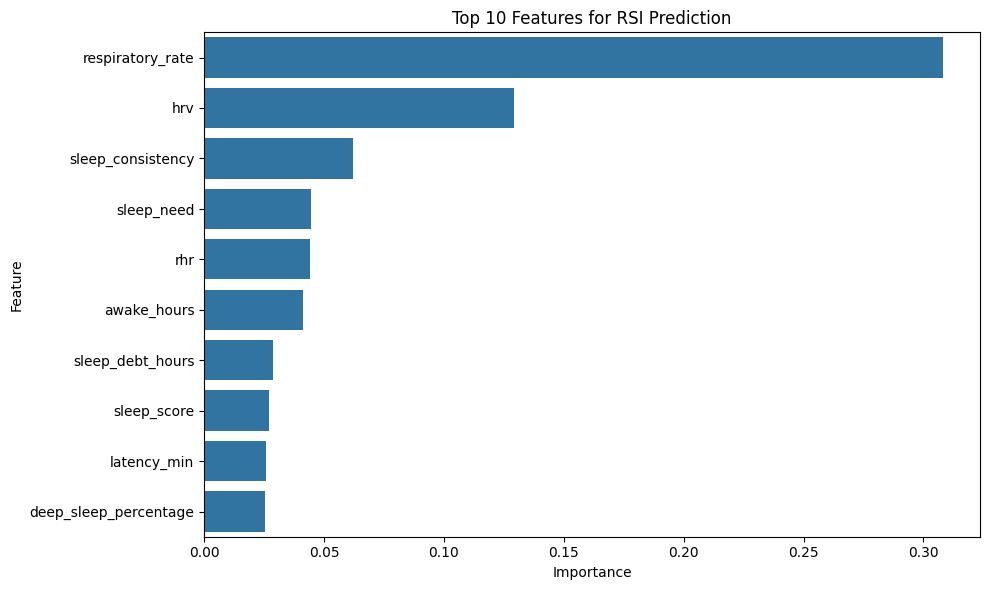

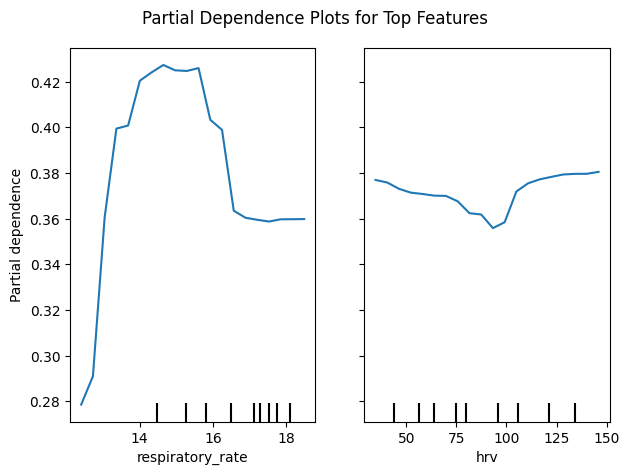

In [ ]:
df_clean = df.dropna(subset=['RSI_filled'])


X_columns = [col for col in df_clean.columns if col not in ['athlete', 'date', 'day_of_week', 'RSI_filled']]
X = df_clean[X_columns]
y = df_clean['RSI_filled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")


feature_importance = pd.DataFrame({
    'Feature': X_columns,
    'Importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Features for RSI Prediction')
plt.tight_layout()
plt.savefig('feature_importance.png')


top_features = feature_importance['Feature'].head(2).tolist()
display = PartialDependenceDisplay.from_estimator(
    rf_model, X_train, features=top_features,
    feature_names=X_columns, n_jobs=2, grid_resolution=20
)
display.figure_.suptitle('Partial Dependence Plots for Top Features')
display.figure_.tight_layout()
display.figure_.savefig('pdp_plots.png')

print("\nTop 10 features for RSI prediction:")
print(feature_importance.head(10))

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb

# Function to evaluate the model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"{model.__class__.__name__} - Test MSE: {test_mse:.4f}, Test R²: {test_r2:.4f}")

    return test_mse, test_r2

# Assuming X_train, X_test, y_train, y_test are already defined
# If not, you would need to load and split your dataset here
# Example: X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of models to evaluate
models = [
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
    xgb.XGBRegressor(random_state=42),
    lgb.LGBMRegressor(random_state=42),
    SVR(),
    KNeighborsRegressor(),
    LinearRegression(),
    ElasticNet(random_state=42),
    DecisionTreeRegressor(random_state=42)
]

# Evaluate each model
results = []

for model in models:
    mse, r2 = evaluate_model(model, X_train, X_test, y_train, y_test)
    results.append((model.__class__.__name__, mse, r2))

# Display the results
results_df = pd.DataFrame(results, columns=['Model', 'Test MSE', 'Test R²'])
print("\nModel Comparison:\n", results_df)

RandomForestRegressor - Test MSE: 0.0034, Test R²: 0.3702
GradientBoostingRegressor - Test MSE: 0.0035, Test R²: 0.3437
XGBRegressor - Test MSE: 0.0037, Test R²: 0.3147
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3886
[LightGBM] [Info] Number of data points in the train set: 1220, number of used features: 24
[LightGBM] [Info] Start training from score 0.372238
LGBMRegressor - Test MSE: 0.0035, Test R²: 0.3393
SVR - Test MSE: 0.0045, Test R²: 0.1656
KNeighborsRegressor - Test MSE: 0.0040, Test R²: 0.2624
LinearRegression - Test MSE: 0.0049, Test R²: 0.0856
ElasticNet - Test MSE: 0.0054, Test R²: -0.0014
DecisionTreeRegressor - Test MSE: 0.0055, Test R²: -0.0198

Model Comparison:
                        Model  Test MSE   Test R²
0      RandomForestRegressor  0.003376  0.370242
1  GradientBoostingRegressor  0.003519  0.343680
2               X

Baseline Random Forest with default parameters:
Training MSE: 0.0012
Test MSE: 0.0034
Training R²: 0.8063
Test R²: 0.3702

--- Grid Search CV ---
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best CV score: 0.0034 (MSE)
Training MSE: 0.0012
Test MSE: 0.0034
Training R²: 0.8091
Test R²: 0.3732

--- Random Search CV ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 139}
Best CV score: 0.0035 (MSE)
Training MSE: 0.0016
Test MSE: 0.0034
Training R²: 0.7364
Test R²: 0.3743

Parameter tuning complete. Results saved to image files.


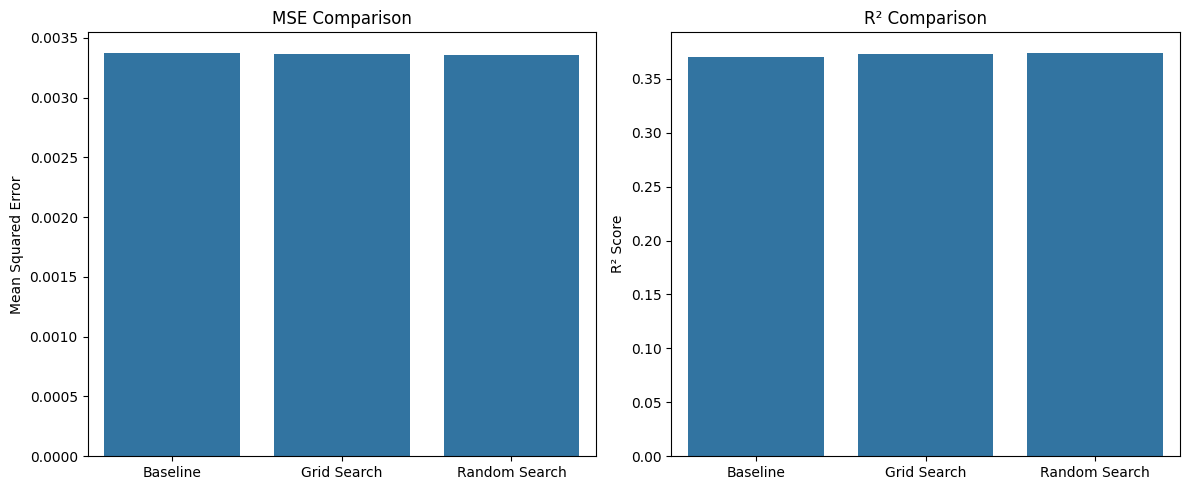

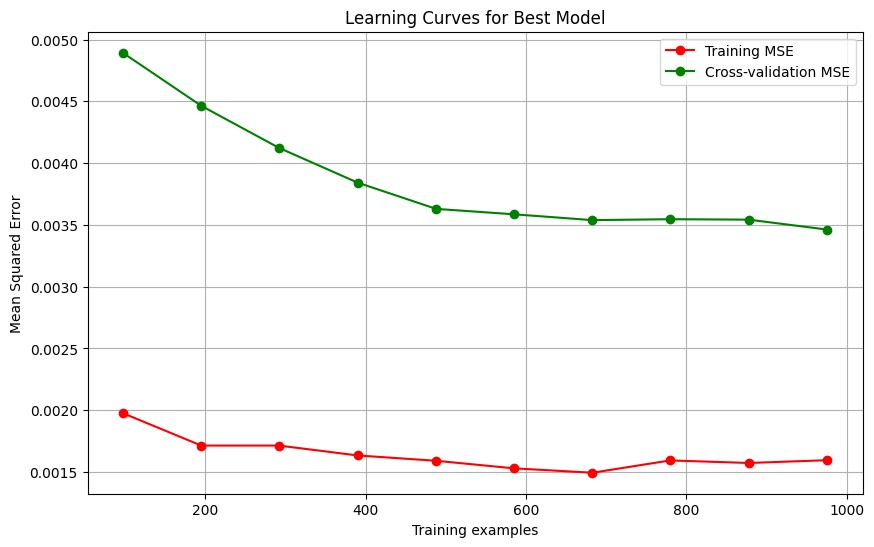

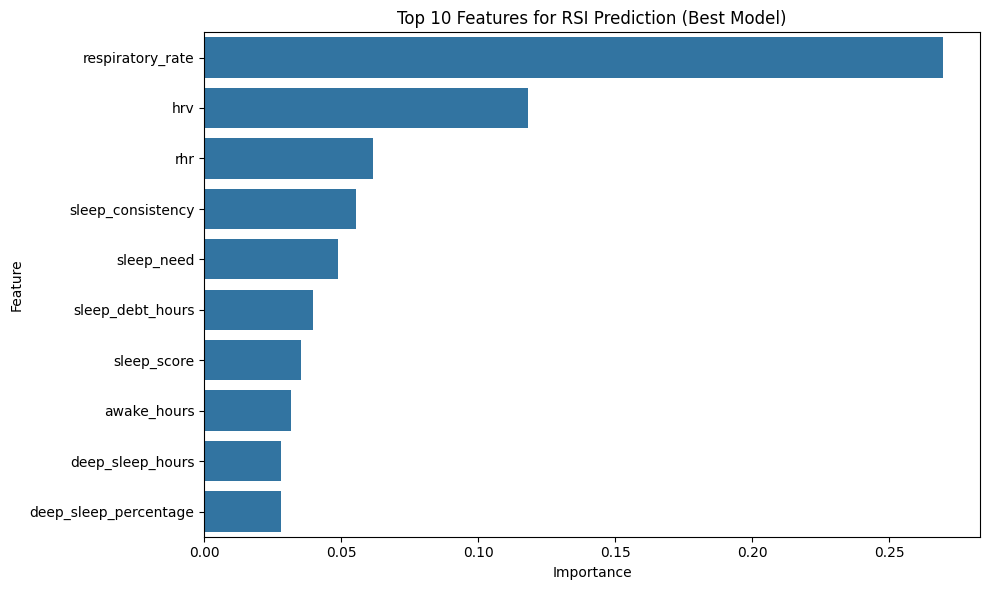

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"Training MSE: {train_mse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    return model, test_mse, test_r2


print("Baseline Random Forest with default parameters:")
baseline_model = RandomForestRegressor(random_state=42)
_, baseline_mse, baseline_r2 = evaluate_model(baseline_model, X_train, X_test, y_train, y_test)



print("\n--- Grid Search CV ---")

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}


grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)


grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {-grid_search.best_score_:.4f} (MSE)")

# Evaluate the best model from Grid Search
best_grid_model = grid_search.best_estimator_
_, grid_mse, grid_r2 = evaluate_model(best_grid_model, X_train, X_test, y_train, y_test)


# 3. Random Search for hyperparameter tuning
print("\n--- Random Search CV ---")

# Define parameter distributions
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [None] + list(range(10, 51, 10)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2', 0.5, 0.3]
}

# Create Random Search object
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit Random Search
random_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best CV score: {-random_search.best_score_:.4f} (MSE)")

# Evaluate the best model from Random Search
best_random_model = random_search.best_estimator_
_, random_mse, random_r2 = evaluate_model(best_random_model, X_train, X_test, y_train, y_test)

# 4. Compare the results
models = ['Baseline', 'Grid Search', 'Random Search']
mse_scores = [baseline_mse, grid_mse, random_mse]
r2_scores = [baseline_r2, grid_r2, random_r2]

# Plot MSE comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=models, y=mse_scores)
plt.title('MSE Comparison')
plt.ylabel('Mean Squared Error')

plt.subplot(1, 2, 2)
sns.barplot(x=models, y=r2_scores)
plt.title('R² Comparison')
plt.ylabel('R² Score')

plt.tight_layout()
plt.savefig('model_comparison.png')

# 5. Learning curves for the best model
from sklearn.model_selection import learning_curve

# Choose the best model
best_model = best_random_model if random_mse < grid_mse else best_grid_model

# Calculate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_squared_error', n_jobs=-1
)

# Convert scores to MSE
train_mse = -np.mean(train_scores, axis=1)
test_mse = -np.mean(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mse, 'o-', color='r', label='Training MSE')
plt.plot(train_sizes, test_mse, 'o-', color='g', label='Cross-validation MSE')
plt.xlabel('Training examples')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curves for Best Model')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('learning_curves.png')

# Feature importance from the best model
feature_importance = pd.DataFrame({
    'Feature': X_columns,
    'Importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Features for RSI Prediction (Best Model)')
plt.tight_layout()
plt.savefig('best_model_feature_importance.png')

print("\nParameter tuning complete. Results saved to image files.")

Top features correlated with RSI:
sleep_need                      0.188608
sleep_debt_hours                0.174189
sleep_consistency               0.131211
sleep_efficiency                0.064249
respiratory_rate                0.026873
rhr                             0.016706
recovery                       -0.010370
latency_min                    -0.020504
restorative_sleep              -0.020548
restorative_sleep_hours        -0.020988
rem_percentage                 -0.025784
light_sleep_hours              -0.047822
sleep_disturbances             -0.073023
rem_sleep_hours                -0.080927
wake_periods                   -0.085690
hrv                            -0.095799
cycles                         -0.101181
awake_hours                    -0.115750
hours_of_sleep                 -0.128227
deep_sleep_percentage          -0.139784
hours_in_bed                   -0.147545
total_cycle_sleep_time_hours   -0.163241
sleep_score                    -0.178308
deep_sleep_hours       

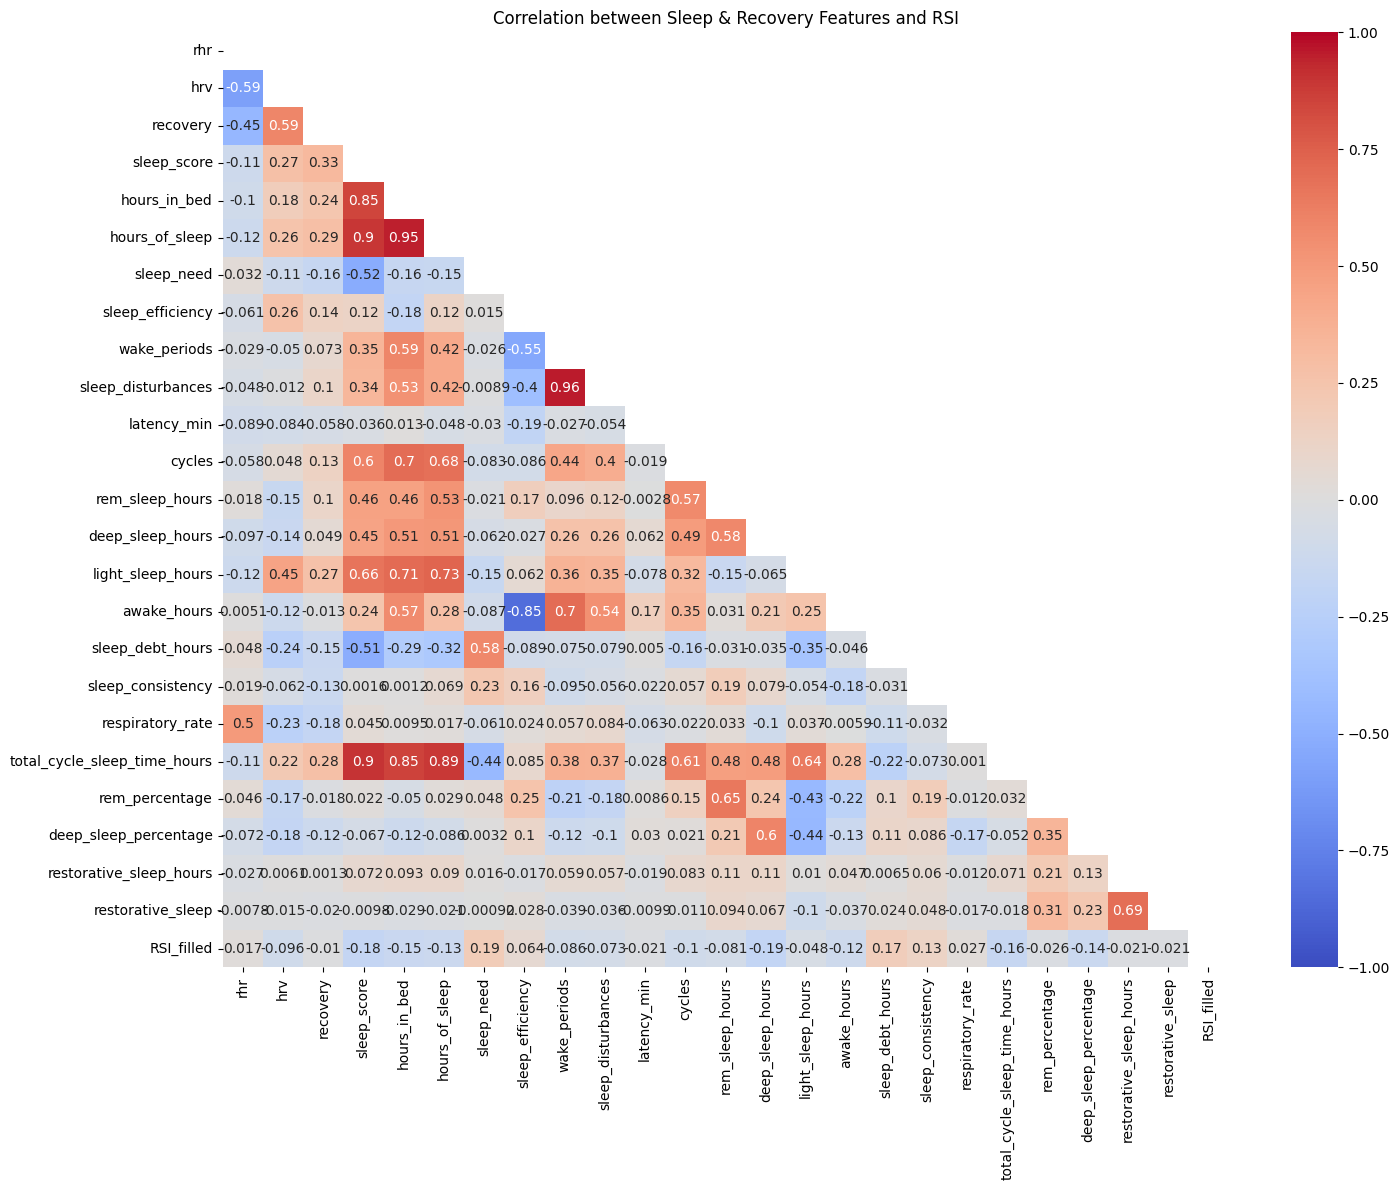

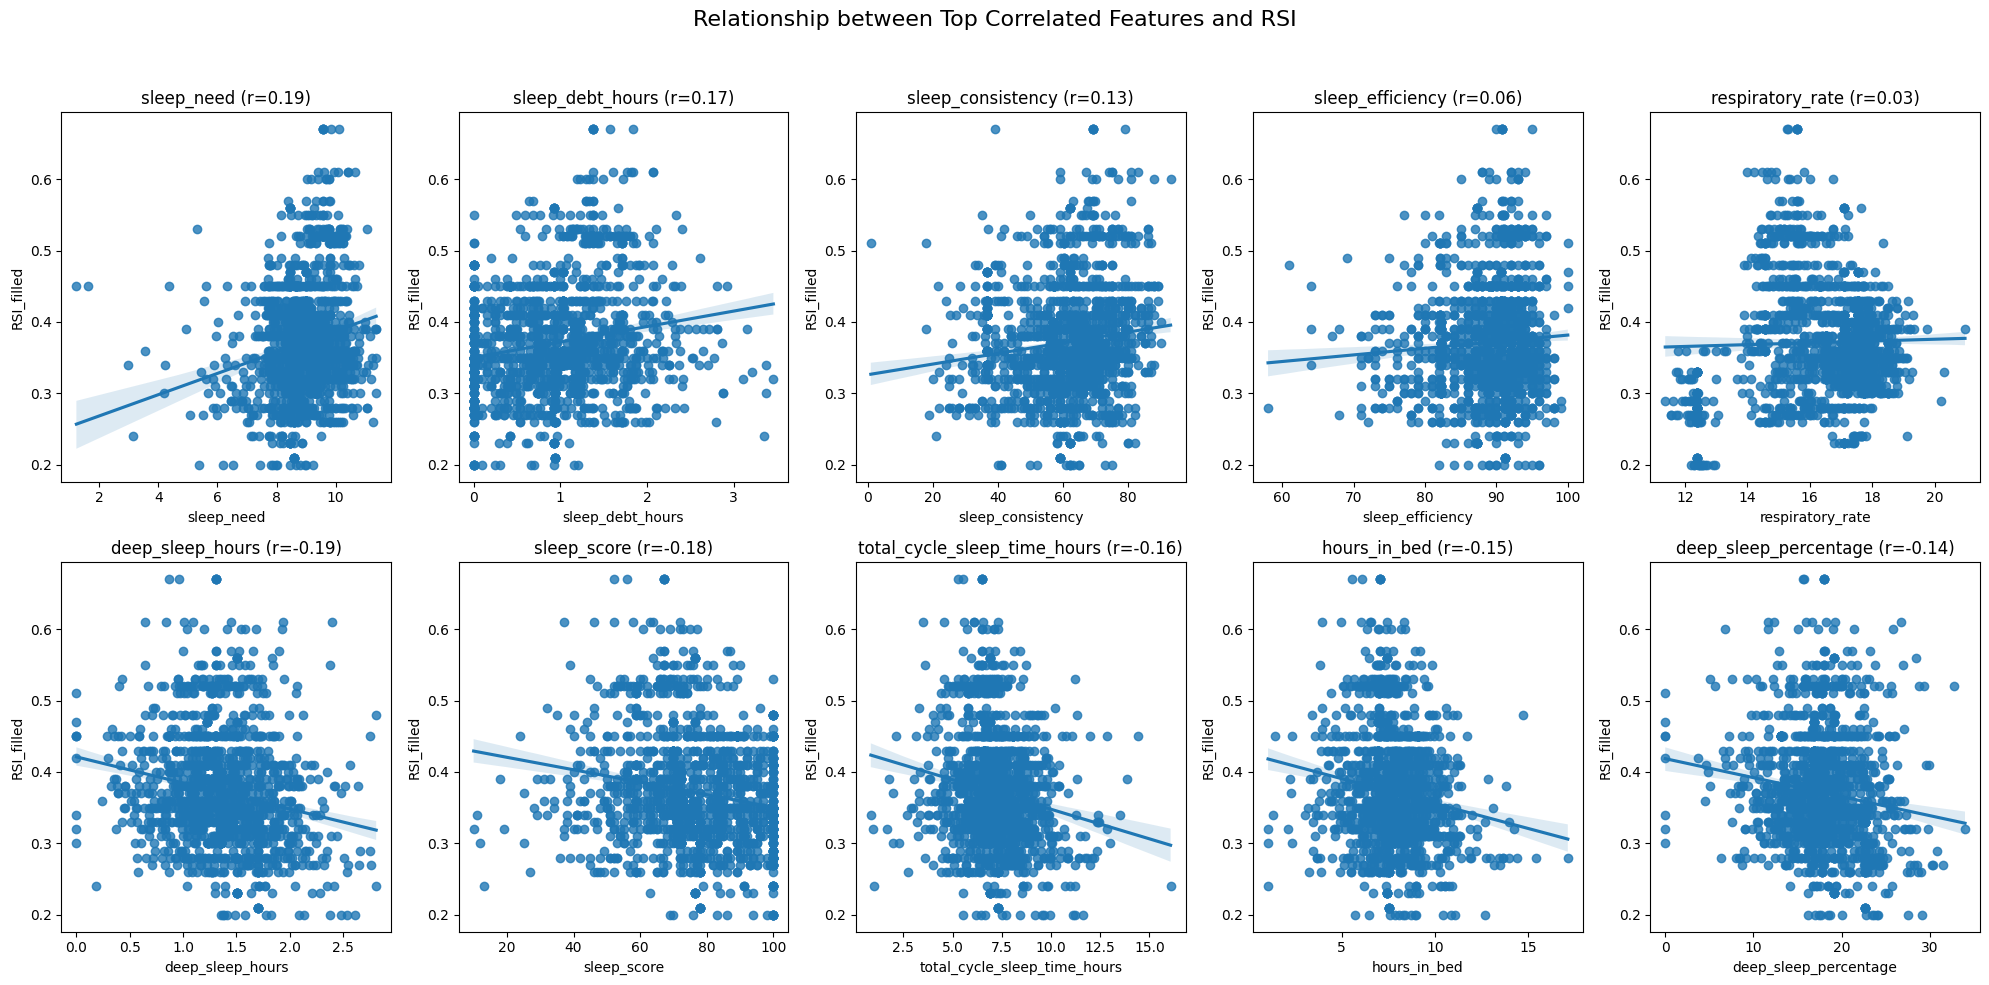

In [ ]:
sleep_recovery_features = [
    'rhr', 'hrv', 'recovery', 'sleep_score', 'hours_in_bed', 'hours_of_sleep',
    'sleep_need', 'sleep_efficiency', 'wake_periods', 'sleep_disturbances',
    'latency_min', 'cycles', 'rem_sleep_hours', 'deep_sleep_hours',
    'light_sleep_hours', 'awake_hours', 'sleep_debt_hours', 'sleep_consistency',
    'respiratory_rate', 'total_cycle_sleep_time_hours', 'rem_percentage',
    'deep_sleep_percentage', 'restorative_sleep_hours', 'restorative_sleep'
]


plt.figure(figsize=(15, 12))
correlation = df[sleep_recovery_features + ['RSI_filled']].corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask)
plt.title('Correlation between Sleep & Recovery Features and RSI')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')


rsi_correlations = correlation['RSI_filled'].drop('RSI_filled').sort_values(ascending=False)
print("Top features correlated with RSI:")
print(rsi_correlations)




top_pos_features = rsi_correlations.nlargest(5).index
top_neg_features = rsi_correlations.nsmallest(5).index

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('Relationship between Top Correlated Features and RSI', fontsize=16)


for i, feature in enumerate(top_pos_features):
    sns.regplot(x=feature, y='RSI_filled', data=df, ax=axes[0, i])
    axes[0, i].set_title(f"{feature} (r={correlation.loc[feature, 'RSI_filled']:.2f})")

for i, feature in enumerate(top_neg_features):
    sns.regplot(x=feature, y='RSI_filled', data=df, ax=axes[1, i])
    axes[1, i].set_title(f"{feature} (r={correlation.loc[feature, 'RSI_filled']:.2f})")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('top_correlations_with_rsi.png')

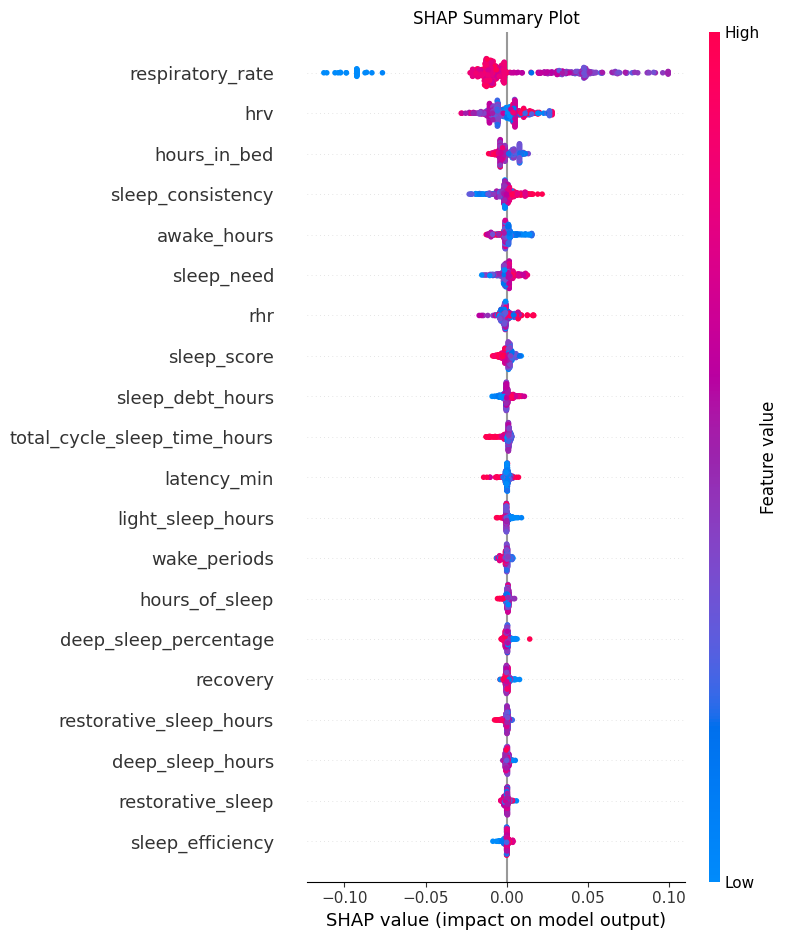

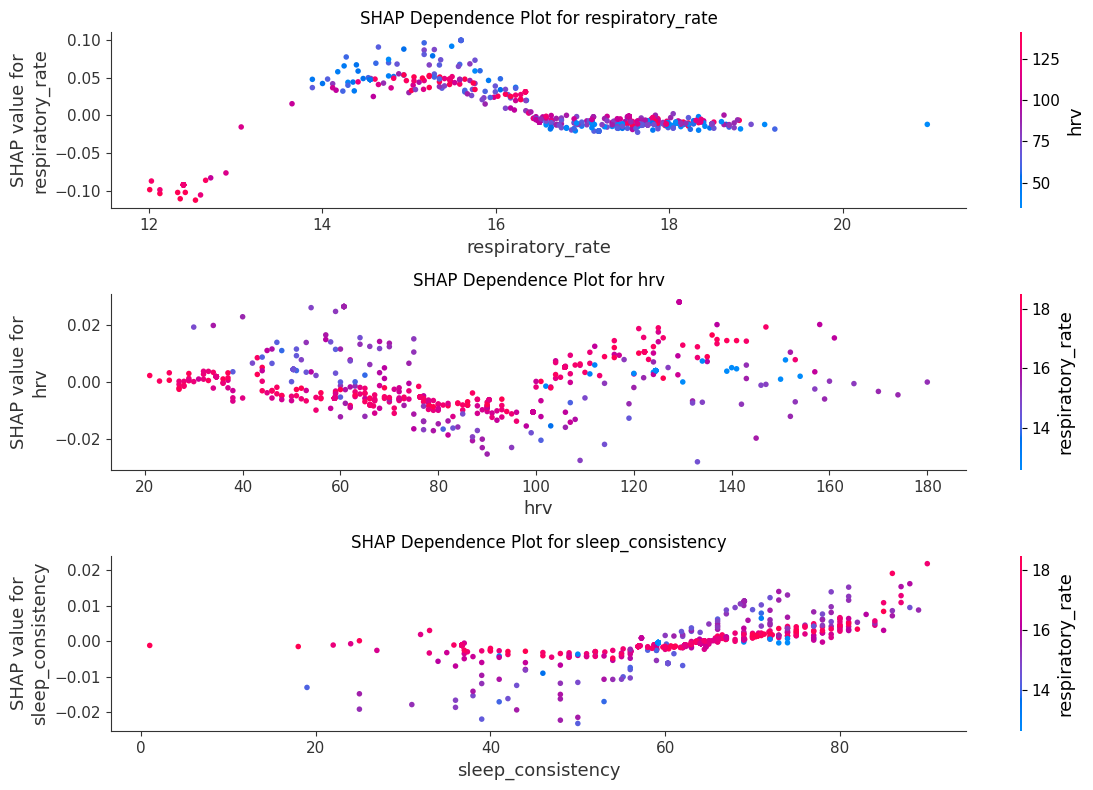

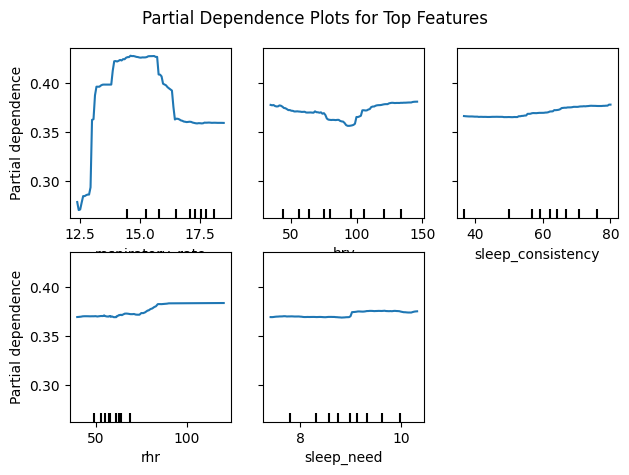

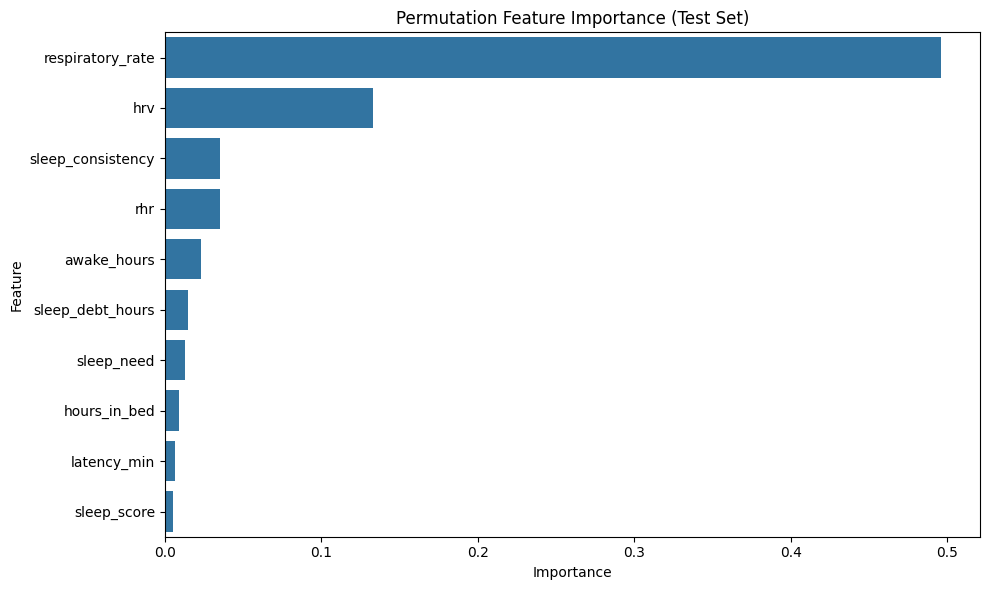

In [ ]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=X_columns, show=False)
plt.title('SHAP Summary Plot')
plt.tight_layout()
plt.savefig('shap_summary.png')

#SHAP analysis for top features
plt.figure(figsize=(12, 8))
for i, feature in enumerate(feature_importance['Feature'].head(3)):
    plt.subplot(3, 1, i+1)
    shap.dependence_plot(feature, shap_values, X_test, feature_names=X_columns,
                          show=False, ax=plt.gca())
    plt.title(f'SHAP Dependence Plot for {feature}')
plt.tight_layout()
plt.savefig('shap_dependence.png')

#Partial Dependence Plots
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

display = PartialDependenceDisplay.from_estimator(
    best_model, X_train, features=feature_importance['Feature'].head(5).tolist(),
    feature_names=X_columns, n_jobs=-1
)

display.figure_.suptitle('Partial Dependence Plots for Top Features')
display.figure_.tight_layout()
display.figure_.savefig('pdp_plots.png')



# Permutation Importance
from sklearn.inspection import permutation_importance

result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
perm_importance = pd.DataFrame({
    'Feature': X_columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_importance.head(10))
plt.title('Permutation Feature Importance (Test Set)')
plt.tight_layout()
plt.savefig('permutation_importance.png')


Cluster 0 Top Features:
             Feature  Importance
18  respiratory_rate    0.286788
1                hrv    0.166713
0                rhr    0.064296
3        sleep_score    0.043117
16  sleep_debt_hours    0.042428

Cluster 1 Top Features:
              Feature  Importance
18   respiratory_rate    0.314686
17  sleep_consistency    0.207853
1                 hrv    0.070973
6          sleep_need    0.058018
16   sleep_debt_hours    0.049301

Cluster 2 Top Features:
                  Feature  Importance
18       respiratory_rate    0.532654
1                     hrv    0.111716
15            awake_hours    0.047490
21  deep_sleep_percentage    0.045890
23      restorative_sleep    0.025837

Cluster 3 Top Features:
              Feature  Importance
18   respiratory_rate    0.114333
16   sleep_debt_hours    0.080960
1                 hrv    0.064778
20     rem_percentage    0.064731
17  sleep_consistency    0.063238

Cluster 4 Top Features:
              Feature  Importance
18   re

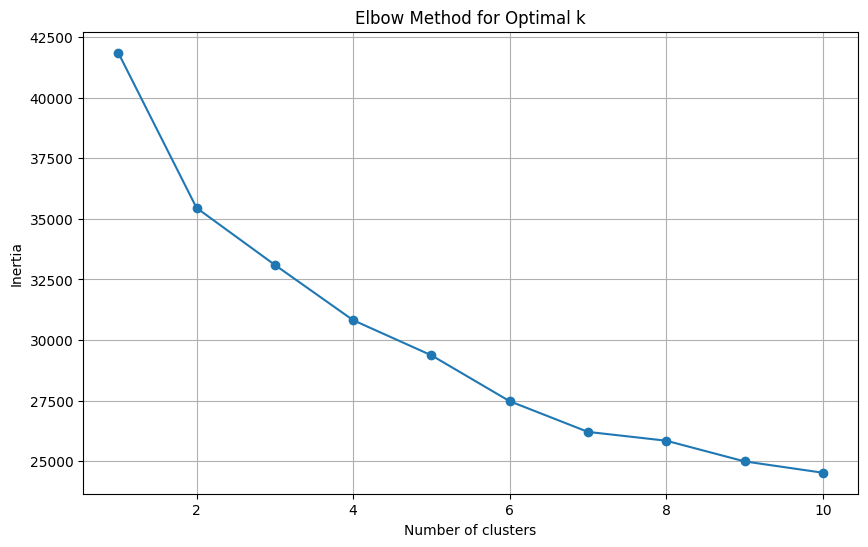

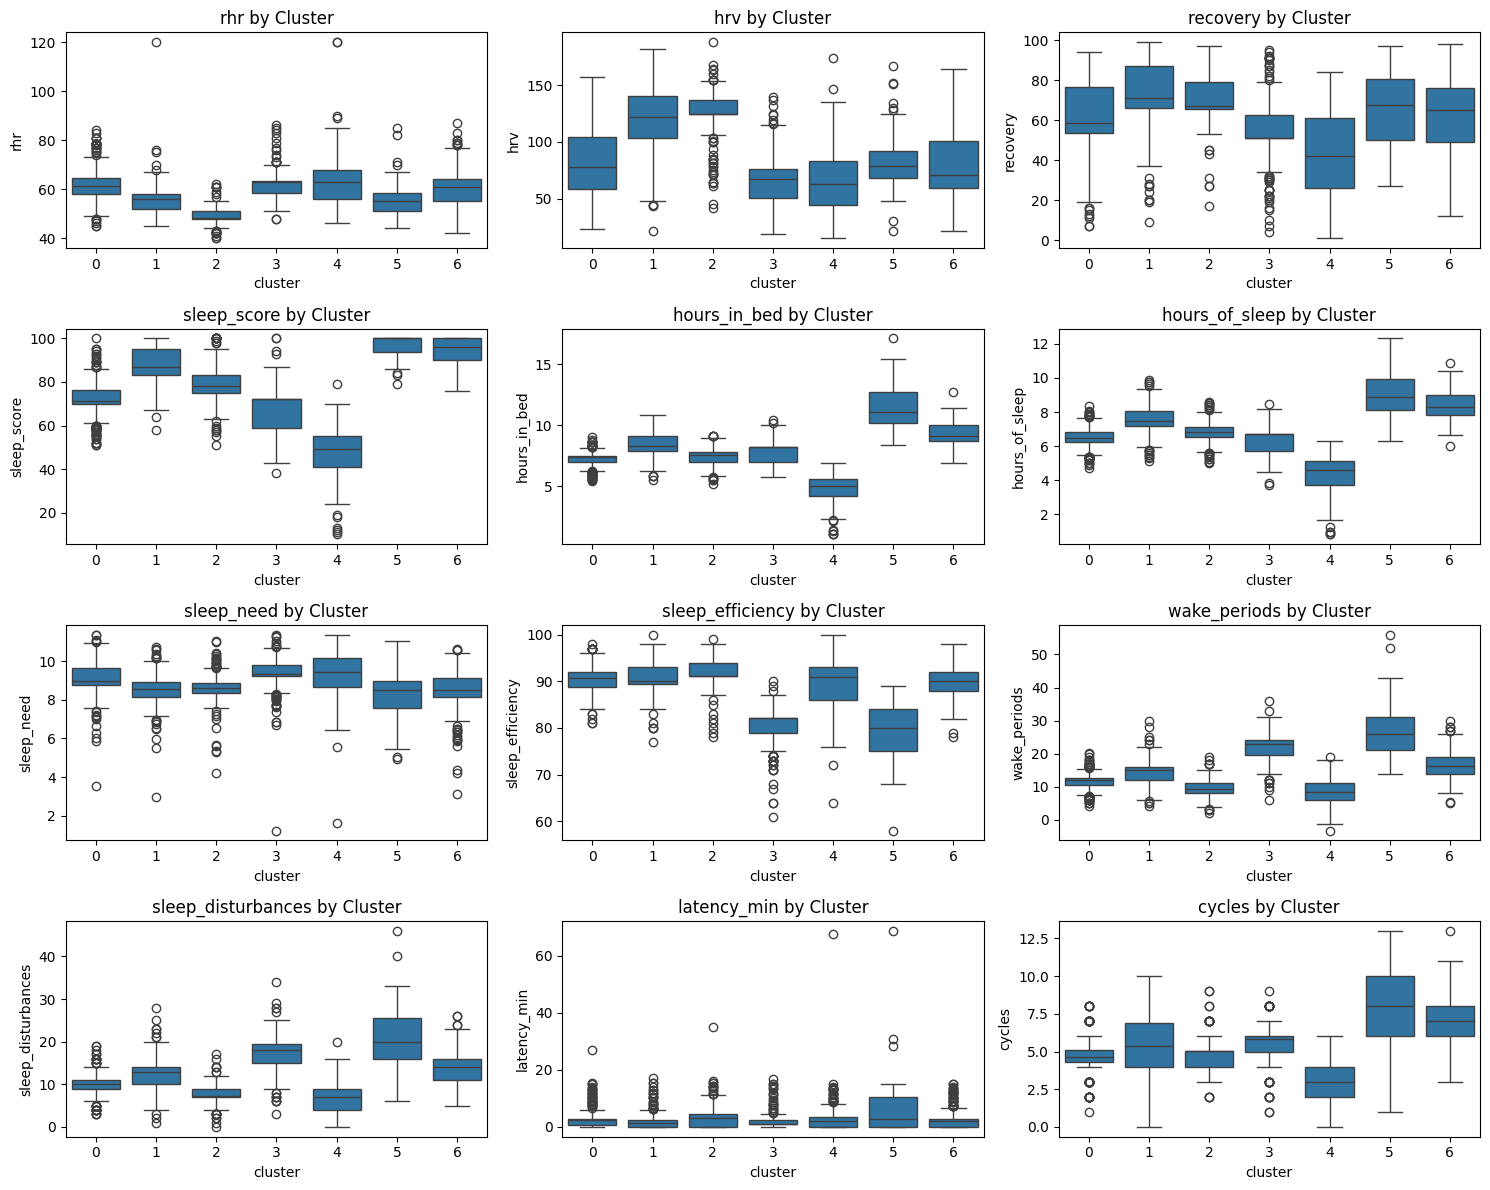

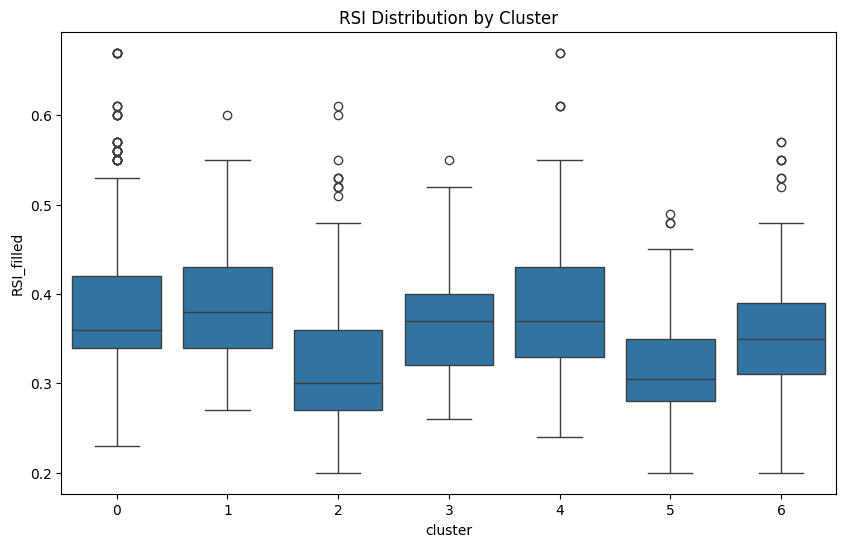

In [ ]:
df_clean = df.dropna(subset=['RSI_filled'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[sleep_recovery_features])

inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.savefig('elbow_method.png')


optimal_k = 7  # Adjust based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(X_scaled)

# Now train separate models for each cluster with clean data
cluster_metrics = []
for cluster_id in range(optimal_k):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    if len(cluster_data) > 20:  # Ensure enough data points
        X_cluster = cluster_data[sleep_recovery_features]
        y_cluster = cluster_data['RSI_filled']  # Use RSI_filled instead of RSI

        # Now proceed with train-test split and modeling
        X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
            X_cluster, y_cluster, test_size=0.2, random_state=42)

        # Use your best parameters from previous tuning
        best_params = {
            'max_depth': 30,
            'min_samples_leaf': 1,
            'min_samples_split': 2,
            'n_estimators': 200
        }

        model_c = RandomForestRegressor(**best_params, random_state=42)
        model_c.fit(X_train_c, y_train_c)

        y_pred_c = model_c.predict(X_test_c)
        mse_c = mean_squared_error(y_test_c, y_pred_c)
        r2_c = r2_score(y_test_c, y_pred_c)

        # Also calculate feature importance for this cluster
        feature_importances = pd.DataFrame({
            'Feature': sleep_recovery_features,
            'Importance': model_c.feature_importances_
        }).sort_values('Importance', ascending=False)

        print(f"\nCluster {cluster_id} Top Features:")
        print(feature_importances.head(5))

        cluster_metrics.append({
            'cluster': cluster_id,
            'size': len(cluster_data),
            'mse': mse_c,
            'r2': r2_c
        })

# Compare cluster models
cluster_metrics_df = pd.DataFrame(cluster_metrics)
print("\nCluster-specific model performance:")
print(cluster_metrics_df)

# Analyze the characteristics of each cluster
plt.figure(figsize=(15, 12))
for i, feature in enumerate(sleep_recovery_features[:min(12, len(sleep_recovery_features))]):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x='cluster', y=feature, data=df_clean)
    plt.title(f'{feature} by Cluster')
plt.tight_layout()
plt.savefig('cluster_features.png')

# RSI distribution by cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='RSI_filled', data=df_clean)
plt.title('RSI Distribution by Cluster')
plt.savefig('rsi_by_cluster.png')